# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

>**Tip**: Though it's not a mandate, students can attempt the classroom quizzes to ensure statistical numeric values are calculated correctly in many cases.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


>**Tip**: Please save your work regularly.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df=pd.read_csv('ab_data.csv')

**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
print("as we see the data set has 294478 rows")

as we see the data set has 294478 rows


**c.** The number of unique users in the dataset.

In [6]:
df.duplicated('user_id').value_counts()

False    290584
True       3894
dtype: int64

In [7]:
print('as we can see from the data and from the test above that there are 290584 unique user_id  so there is 290584')

as we can see from the data and from the test above that there are 290584 unique user_id  so there is 290584


In [8]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**d.** The proportion of users converted.

In [9]:
df14=df[df['converted']==1]
df14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35237 entries, 4 to 294443
Data columns (total 5 columns):
user_id         35237 non-null int64
timestamp       35237 non-null object
group           35237 non-null object
landing_page    35237 non-null object
converted       35237 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


In [10]:
a=35237/294478
print(a*100)

11.96591935560551


In [ ]:
print('the proportion of users converted is 11.9659 as there is 35237 converted user amang 294478 user of all the test ')

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [11]:
df.groupby(['group'])['landing_page'].value_counts()

group      landing_page
control    old_page        145274
           new_page          1928
treatment  new_page        145311
           old_page          1965
Name: landing_page, dtype: int64

In [ ]:
print('there is 1965 user in the treatment group who recieved the old page')

**f.** Do any of the rows have missing values?

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
print(' there isnot any row with missing value')

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [13]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
dfa=df.drop(df[(df.group =="treatment")&(df.landing_page != "new_page")].index)

df2=dfa.drop(dfa[(df.group =="control")&(dfa.landing_page != "old_page")].index)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [14]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [15]:
df2.duplicated('user_id').value_counts()

False    290584
True          1
dtype: int64

In [ ]:
print(' as we see there are 290584 unique user in df2')

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [ ]:
df2.duplicated(subset=None,keep='first')


**c.** Display the rows for the duplicate **user_id**? 

In [16]:
df2.drop_duplicates(subset=['user_id'],inplace=True)

**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [17]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 

# Check again if the row with a duplicate user_id is deleted or not

df2.duplicated('user_id').value_counts()

False    290584
dtype: int64

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [18]:
dfe=df2[df2['converted']==1]
dfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34753 entries, 4 to 294443
Data columns (total 5 columns):
user_id         34753 non-null int64
timestamp       34753 non-null object
group           34753 non-null object
landing_page    34753 non-null object
converted       34753 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


In [19]:
d=34753/290584*100
print(d)

11.959708724499627


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
df2.groupby(['group'])['converted'].value_counts()

group      converted
control    0            127785
           1             17489
treatment  0            128046
           1             17264
Name: converted, dtype: int64

In [21]:
l=17489/(127785+17489)*100
print(l)

12.03863045004612


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
c=17264/(17264+128046)*100
print(c)

11.880806551510565


>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [23]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff=c-l
print(obs_diff)

-0.15782389853555578


**d.** What is the probability that an individual received the new page?

In [24]:
m=(128047+17264)/290584*100
print(m)

50.00653855683726


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Your answer goes here.**as we can see that the new treatment didnot lead to more conversions as that the probability of converted users from the treatmnt group_11.88%_is even less than the probability of converted users from control group_12%_ 

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Put your answer here.**null hypothesis is $p_{old}>=$p_{new},alternative hypothesis is $p_{old}<$p_{new}

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [25]:
pnew=d
print(pnew)

11.959708724499627


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [26]:
p_old=d
print(p_old)

11.959708724499627


**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [27]:
df2[df2['group']=='treatment']

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
10,929503,2017-01-18 05:37:11.527370,treatment,new_page,0
11,834487,2017-01-21 22:37:47.774891,treatment,new_page,0
12,803683,2017-01-09 06:05:16.222706,treatment,new_page,0
13,944475,2017-01-22 01:31:09.573836,treatment,new_page,0
14,718956,2017-01-22 11:45:11.327945,treatment,new_page,0


**d.** What is $n_{old}$, the number of individuals in the control group?

In [28]:
n_new=145310
n_old=290584-145310
print(n_new,n_old)

145310 145274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [29]:
# Simulate a Sample for the treatment Group
treatment=df2.query('group=="treatment"').converted.mean()

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [30]:
# Simulate a Sample for the control Group
control=df2.query('group=="control"').converted.mean()


**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [31]:
control,treatment

(0.1203863045004612, 0.11880806551510564)

In [32]:
diff=treatment-control
diff

-0.0015782389853555567


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [33]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    b_samp=df.sample(20,replace=True)
    control= b_samp.query('group=="control"').converted.mean()
    treatment= b_samp.query('group=="treatment"').converted.mean()
    p_diffs.append(treatment-control)



In [34]:
p_diffs=np.array(p_diffs)


**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

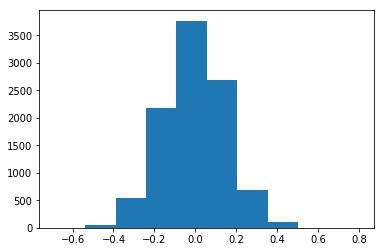

In [35]:
plt.hist(p_diffs);

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [36]:
np.std(p_diffs)

0.15096363200341564

In [37]:
null_vals=np.random.normal(0,np.std(p_diffs))

In [38]:
(null_vals>p_diffs).mean()

0.058599999999999999

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**Put your answer here.**p_value,that there is no change in the converted number from the new page and that the new page is equal to the old page or even worse and that we accept the null hypothesis 



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [39]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old =  17489

# number of conversions with the new_page
convert_new = 17264

# number of individuals who were shown the old_page
n_old = n_old

# number of individuals who received new_page
n_new = n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [40]:
nobs_array=np.array([n_old,n_new])
count_array=np.array([convert_old,convert_new])

In [41]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count_array,nobs_array,alternative='larger')
print(z_score, p_value)

1.31092419842 0.094941687241


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

>**Put your answer here.**that in both p_value and z_score the new page didnot make a change in the converted rate and the both accspt our null hypothesis that the new page is equal or worse than the old page in converted rate

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Put your answer here.**liner regression 

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [42]:
converted_dummies = pd.get_dummies(df['group'])
df_new = df2.join(converted_dummies)
df_new.head()

,user_id,timestamp,group,landing_page,converted,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [43]:
df_new.drop('control',axis=1,inplace=True)
df_new.drop('group',axis=1,inplace=True)

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [44]:
df_new['intercept']=1
lm = sm.OLS(df_new['converted'], df_new[['intercept', 'treatment']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Sat, 19 Mar 2022   Prob (F-statistic):              0.190
Time:                        20:03:58   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
treatment     -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**Put your answer here.**they are the same, the both two sides,the both have very low p_value

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms 
into your regression model?
>**Put your answer here.**as we can see form the analysis that we cannot know what is making convert rate goes up or down it is a good idea to have other factor to understand the convert rate more 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [45]:
# Read the countries.csv
df3=pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [57]:
# Join with the df2 dataframe
dfe=df_new.merge(df3, left_on='user_id', right_on='user_id')

In [58]:
dfe.head()

,user_id,timestamp,landing_page,converted,treatment,intercept,country
0,851104,2017-01-21 22:11:48.556739,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,old_page,1,0,1,US


In [59]:
# Create the necessary dummy variables
dummy=pd.get_dummies(dfe['country'])
df4=dfe.join(dummy)
df4.head()

,user_id,timestamp,landing_page,converted,treatment,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,0,1,US,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [60]:
# Fit your model, and summarize the results
df4['intercept']=1
lm = sm.OLS(df4['converted'], df4[['intercept', 'US']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01634
Date:                Sat, 19 Mar 2022   Prob (F-statistic):              0.898
Time:                        20:14:12   Log-Likelihood:                -85268.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1197      0.001    108.797      0.000       0.118       0.122
US            -0.0002      0.001     -0.128      0.898      -0.003       0.002
==============================================================================
Omnibus:                   125554.657   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414321.504
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         3.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
df4['intercept']=1
lm = sm.OLS(df4['converted'], df4[['intercept', 'UK']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9121
Date:                Sat, 19 Mar 2022   Prob (F-statistic):              0.340
Time:                        20:15:06   Log-Likelihood:                -85268.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1193      0.001    171.656      0.000       0.118       0.121
UK             0.0013      0.001      0.955      0.340      -0.001       0.004
==============================================================================
Omnibus:                   125554.026   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414317.226
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>**Put your conclusion answer here.**as we can see nor the new page or the old page give us high understanding for the factors that affect convert rate as we can see from adj.r_squared and even contries doesnot effect alot as we can see from the adj.r_squared in any of the countries model 

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])